In [1]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("Python Spark SQL basic example") \
    .config("spark.jars.packages", "com.datastax.spark:spark-cassandra-connector_2.11:2.0.1") \
    .getOrCreate()


In [13]:
load_options = { "table": "unique_tags", "keyspace": "movies", "spark.cassandra.connection.host": "cassandra"}
tags = spark.read.format("org.apache.spark.sql.cassandra").options(**load_options).load()
tags.registerTempTable("tags")
load_options = { "table": "ratings", "keyspace": "movies", "spark.cassandra.connection.host": "cassandra"}
ratings = spark.read.format("org.apache.spark.sql.cassandra").options(**load_options).load()
ratings.registerTempTable("ratings")
load_options = { "table": "imdb_basics", "keyspace": "movies", "spark.cassandra.connection.host": "cassandra"}
imdb = spark.read.format("org.apache.spark.sql.cassandra").options(**load_options).load()
imdb.registerTempTable("imdb")
load_options = { "table": "links", "keyspace": "movies", "spark.cassandra.connection.host": "cassandra"}
imdb = spark.read.format("org.apache.spark.sql.cassandra").options(**load_options).load()
imdb.registerTempTable("links")




### How many unique tags are there?

In [3]:
spark.sql("""
SELECT count(DISTINCT tag)
FROM tags
""").show()

+-------------------+
|count(DISTINCT tag)|
+-------------------+
|              38642|
+-------------------+



### What is the average number of movies released in each year?

In [7]:
spark.sql("""
SELECT startYear, count(*)
FROM imdb
GROUP BY startYear
""").show()

+---------+--------+
|startYear|count(1)|
+---------+--------+
|   1988.0|   25883|
|   1976.0|   19101|
|   1951.0|    6333|
|   1940.0|    2396|
|   2024.0|       3|
|   1928.0|    3065|
|   1900.0|    1834|
|   1979.0|   20033|
|   1953.0|    7824|
|   1913.0|    9562|
|   1987.0|   26749|
|   1909.0|    5420|
|   1959.0|   13272|
|   1934.0|    2701|
|   1904.0|    1830|
|   1978.0|   19401|
|   1968.0|   18150|
|   2010.0|  178865|
|   2022.0|      25|
|     null|  322109|
+---------+--------+
only showing top 20 rows



### What is the variance in ratings for a single user?

In [5]:
spark.sql("""
SELECT variance(rating)
FROM ratings
WHERE userid = 1535
""").show()

+------------------+
|  var_samp(rating)|
+------------------+
|0.2841954022988506|
+------------------+



### How has the average rating of users changed over time?

In [27]:
years = spark.sql("""
SELECT year, avg(rating) as avg_rating
FROM (
    SELECT cast(from_unixtime(timestamp, 'yyyy') as int) as year, rating
    FROM ratings
) GROUP BY year
ORDER BY year ASC
""").toPandas()

In [25]:
from ggplot import *

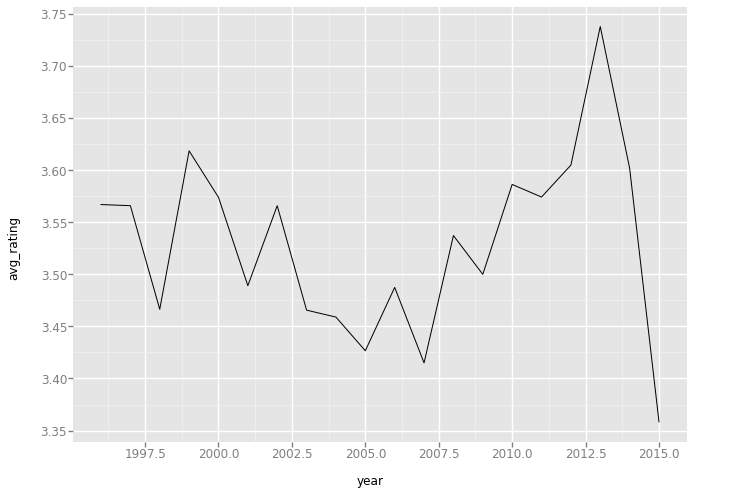

<ggplot: (8789394688299)>

In [28]:
ggplot(aes(x='year', y='avg_rating'), data=years) + geom_line()

### What are the most popular words among all movie titles?

In [55]:
spark.sql("""
SELECT word, count(*) as c
FROM (
SELECT explode(words) as word
FROM (
SELECT explode(sentences(primarytitle)) as words
from imdb
WHERE titletype = 'movie'
))
GROUP BY word
ORDER BY c DESC
""").show(truncate=False)

+----+-----+
|word|c    |
+----+-----+
|The |59652|
|of  |34710|
|the |31330|
|in  |10999|
|A   |10567|
|de  |10433|
|and |10107|
|a   |8945 |
|to  |7894 |
|La  |6468 |
|no  |6005 |
|Love|5738 |
|for |4077 |
|My  |4046 |
|I   |3889 |
|El  |3754 |
|la  |3695 |
|Man |3459 |
|Life|3312 |
|on  |3277 |
+----+-----+
only showing top 20 rows



#### Showing movies with 'Man' in the title as an example

In [58]:
spark.sql("""
SELECT *
FROM imdb
WHERE primarytitle LIKE '%Man %'
""").show()

+---------+-------------+--------------------+--------------------+-------+--------+--------------------+--------------------+--------------+---------+---------+--------------------+
|   tconst|averagerating|           directors|              genres|isadult|numvotes|        primarytitle|       principalcast|runtimeminutes|startyear|titletype|             writers|
+---------+-------------+--------------------+--------------------+-------+--------+--------------------+--------------------+--------------+---------+---------+--------------------+
|tt3243882|         null|           nm0029607|               Adult|  false|    null|Lexington: The Ma...|nm2613011,nm14524...|          null|   2013.0|    video|                null|
|tt0061948|          6.3|           nm0303227|               Drama|  false|    45.0|     The Man Outside|nm0312350,nm00939...|          97.0|   1967.0|    movie|nm0093972,nm03032...|
|tt0416955|         null|                null|               Short|  false|    null| 

### Can we group users into profiles based on their rating history?

#### Join ratings to the imdb dataset via the links table

In [116]:
user_profiles = spark.sql("""
SELECT ratings.rating, ratings.userid, imdb.genres
FROM links
JOIN ratings ON links.movieid = ratings.movieid
JOIN imdb ON CAST(substr(imdb.tconst, 3) as INT) = links.imbdid
""").persist()
user_profiles.show()

+------+------+--------------------+
|rating|userid|              genres|
+------+------+--------------------+
|   3.0|  3284|       Drama,Romance|
|   3.5|  1568|       Drama,Romance|
|   3.5|  2309|       Drama,Romance|
|   4.5|  4276|       Drama,Romance|
|   4.5|  1966|       Drama,Romance|
|   5.0|  2762|Adventure,Drama,R...|
|   4.0|  3768|Adventure,Drama,R...|
|   3.0|  5832|Adventure,Drama,R...|
|   5.0|   741|Adventure,Drama,R...|
|   3.0|  6709|Adventure,Drama,R...|
|   3.0|   104|Adventure,Drama,R...|
|   4.5|  2469|Adventure,Drama,R...|
|   4.5|  1746|Adventure,Drama,R...|
|   2.5|  6373|Adventure,Drama,R...|
|   3.0|  4973|Adventure,Drama,R...|
|   5.0|  4222|Adventure,Drama,R...|
|   4.5|  4486|Adventure,Drama,R...|
|   4.5|  1515|Adventure,Drama,R...|
|   5.0|  1140|Adventure,Drama,R...|
|   4.0|  3625|Adventure,Drama,R...|
+------+------+--------------------+
only showing top 20 rows



In [28]:
user_profiles.registerTempTable("user_profiles")

#### Make one line per rating-genre instead of per rating-movie by expanding out each row to be 1 row per genre within that movie

In [47]:
user_profiles_genre = spark.sql("""
SELECT userid, rating, explode(split(genres, ',')) as genre
FROM user_profiles
""")
user_profiles_genre.registerTempTable("user_profiles_genre")

In [46]:
user_profiles_genre.show(5)

+------+------+-------+
|userid|rating|  genre|
+------+------+-------+
|  3284|   3.0|  Drama|
|  3284|   3.0|Romance|
|  1568|   3.5|  Drama|
|  1568|   3.5|Romance|
|  2309|   3.5|  Drama|
+------+------+-------+
only showing top 5 rows



#### Get top 10 genres

In [119]:
top_genres = spark.sql("""
SELECT genre, count(*) as count
FROM user_profiles_genre
GROUP BY genre
ORDER by count DESC
LIMIT 10
""").persist()
top_genres.registerTempTable("top_genres")
top_genres.show()

+---------+------+
|    genre| count|
+---------+------+
|    Drama|494668|
|   Comedy|367723|
|   Action|252796|
|Adventure|249086|
|    Crime|192021|
|  Romance|158370|
| Thriller|153041|
|   Sci-Fi|115751|
|  Fantasy|104204|
|  Mystery| 81931|
+---------+------+



#### Filter out the user ratings for only the top 10 genres

In [53]:
user_profiles_genre_top_10 = spark.sql("""
SELECT user_profiles_genre.*
FROM user_profiles_genre
JOIN top_genres ON top_genres.genre = user_profiles_genre.genre
""").persist()
user_profiles_genre_top_10.registerTempTable("user_profiles_genre_top_10")
user_profiles_genre_top_10.count()

2169591

In [58]:
user_profiles_genre_top_10.show(5)

+------+------+-------+
|userid|rating|  genre|
+------+------+-------+
|  3284|   3.0|  Drama|
|  3284|   3.0|Romance|
|  1568|   3.5|  Drama|
|  1568|   3.5|Romance|
|  2309|   3.5|  Drama|
+------+------+-------+
only showing top 5 rows



#### Get average rating per genre

In [63]:
user_average_rating_per_genre = spark.sql("""
SELECT userid, genre, avg(rating) as rating
FROM user_profiles_genre_top_10
GROUP BY userid, genre
""").persist()
user_average_rating_per_genre.registerTempTable("user_average_rating_per_genre")
user_average_rating_per_genre.show(5)

+------+---------+------------------+
|userid|    genre|            rating|
+------+---------+------------------+
|  1568|    Drama|3.4171779141104293|
|  4222|Adventure|3.9038461538461537|
|  1135|   Comedy|3.2447257383966246|
|  2005|Adventure| 3.423469387755102|
|   471|   Comedy| 3.315934065934066|
+------+---------+------------------+
only showing top 5 rows



#### Make an array where each value is the average rating for a specific genre for that user. If the user didn't rate a genre, set it to 2.5

In [105]:
user_features = spark.sql("""
SELECT userid
  ,array( MAX( if(genre = 'Drama', rating, 2.5) )
  ,MAX( if(genre = 'Comedy', rating, 2.5) )
  ,MAX( if(genre = 'Action', rating, 2.5) )
  ,MAX( if(genre = 'Adventure', rating, 2.5) )
  ,MAX( if(genre = 'Crime', rating, 2.5) )
  ,MAX( if(genre = 'Romance', rating, 2.5) )
  ,MAX( if(genre = 'Thriller', rating, 2.5) )
  ,MAX( if(genre = 'Sci-Fi', rating, 2.5) )
  ,MAX( if(genre = 'Fantasy', rating, 2.5) )
  ,MAX( if(genre = 'Mystery', rating, 2.5) )) as array_features
FROM user_average_rating_per_genre
GROUP BY userid
""").persist()
user_features.count()

6743

In [114]:
user_features.show()

+------+--------------------+
|userid|      array_features|
+------+--------------------+
|  2214|[3.08139534883720...|
|  1677|[2.75892857142857...|
|   474|[4.12121212121212...|
|  5409|[4.22222222222222...|
|    29|[3.54117647058823...|
|   964|[3.75531914893617...|
|  1697|[3.44, 3.5, 3.733...|
|  2250|[3.36666666666666...|
|  4894|[4.46153846153846...|
|  4823|[2.675, 3.2155172...|
|  3091|[4.0, 3.666666666...|
|  3506|[3.75, 2.8, 3.708...|
|    26|[3.70967741935483...|
|  2040|[3.46666666666666...|
|  5556|[3.41666666666666...|
|  2509|[4.32142857142857...|
|  1806|[3.47777777777777...|
|  6721|[3.95, 3.63043478...|
|  2927|[4.54545454545454...|
|  2529|[3.99186991869918...|
+------+--------------------+
only showing top 20 rows



#### Convert the arrays to vectors

In [106]:
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.functions import udf
list_to_vector_udf = udf(lambda l: Vectors.dense(l), VectorUDT())
user_features_vector = user_features.withColumn("features", list_to_vector_udf(user_features["array_features"])).persist()

#### Run K-means to find clusters

In [109]:
from pyspark.ml.clustering import KMeans
kmeans = KMeans().setK(5).setSeed(1)
model = kmeans.fit(user_features_vector)

In [110]:
model.clusterCenters()

[array([ 3.93979085,  3.66221042,  3.60989922,  3.69382825,  3.92316072,
         3.74491668,  3.86306208,  3.61497009,  3.6637981 ,  4.0251613 ]),
 array([ 3.13443769,  2.89136456,  2.80996144,  2.89552402,  3.04036622,
         2.97911897,  2.95548942,  2.8200217 ,  2.91326227,  2.93743451]),
 array([ 3.5970148 ,  3.27293367,  3.18670232,  3.27667175,  3.57371493,
         3.37325683,  3.48681869,  3.19204615,  3.26238953,  3.603238  ]),
 array([ 4.25650413,  4.06026702,  4.12831383,  4.19246469,  4.24075282,
         4.13578148,  4.23325178,  4.11196686,  4.19718261,  4.21331062]),
 array([ 3.76557656,  3.58547697,  3.6613167 ,  3.7716317 ,  3.66067028,
         3.64008411,  3.52101257,  3.57330586,  3.75443242,  2.95421596])]